## Model - resblockCBAM YOLOv8 (attention)
## type - All In One 
## Dataset - Extended
## Test - VisDrone 

# 1. Install Dependencies

In [1]:
# !git clone https://github.com/RuiyangJu/Fracture_Detection_Improved_YOLOv8.git
!git clone https://github.com/mohitsharma-iitj/SEblock_yolov8.git


Cloning into 'SEblock_yolov8'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 192 (delta 29), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (192/192), 3.00 MiB | 13.59 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
%cd SEblock_yolov8

/kaggle/working/SEblock_yolov8


In [3]:
%pip install -r requirements.txt

  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.8/530.8 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00
  C

# 2. Dataset Preparation (Annotation)

as the format of annotation is as - object-class,x_center,y_center,width,height (all normalized as this is input format for YOLO5 prediction)

igiven annotation (in pixel) - bbox_left, bbox_top, bbox_width, bbox_height, score, object_category, truncation, occlusion

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

os.makedirs('/kaggle/working/yolo_dataset/images', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/labels', exist_ok=True)


os.makedirs('/kaggle/working/yolo_dataset/images/train', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/images/val', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/images/test', exist_ok=True)

os.makedirs('/kaggle/working/yolo_dataset/labels/train', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/labels/val', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/labels/test', exist_ok=True)

In [5]:
# Function to get image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height


# Function to convert annotations
def convert_to_yolo_format(filename, annotations, img_width, img_height,output_annotations_path):
    with open(os.path.join(output_annotations_path, filename), 'w') as out_file:
        for annotation in annotations:
            if len(annotation) != 8:
                print(f"Error parsing annotation in {filename}: {annotation}")
                print(f"Ignoring malformed annotation: {annotation}")
                continue
            x_min, y_min, width, height, score, class_id, truncation, occlusion = map(float, annotation)
            if(class_id==0):
                continue
            # Convert to YOLO format
            center_x = x_min + (width / 2.0)
            center_y = y_min + (height / 2.0)
            center_x /= img_width
            center_y /= img_height
            width /= img_width
            height /= img_height
            class_id = class_id -1
            out_file.write(f"{int(class_id)} {center_x} {center_y} {width} {height}\n")

In [6]:
def create_dataset(annotations_path,images_path,output_dataset_path,xx):
    lab_ = 'labels/'+ xx
    img_ = 'images/'+ xx
    output_annotations_path = os.path.join(output_dataset_path, lab_)
    output_images_path = os.path.join(output_dataset_path, img_)


    os.makedirs(output_annotations_path, exist_ok=True)
    os.makedirs(output_images_path, exist_ok=True)

    # Process all annotation files
    for annotation_file in os.listdir(annotations_path):
        image_file = annotation_file.replace('.txt', '.jpg')
        image_path = os.path.join(images_path, image_file)

        if not os.path.exists(image_path):
            continue

        img_width, img_height = get_image_dimensions(image_path)

        with open(os.path.join(annotations_path, annotation_file), 'r') as file:
            lines = file.readlines()
            annotations = [line.strip().split(',') for line in lines]
            convert_to_yolo_format(annotation_file, annotations, img_width, img_height,output_annotations_path)

            # Copy the image to the new dataset location
            output_image_path = os.path.join(output_images_path, image_file)
            if not os.path.exists(output_image_path):
                Image.open(image_path).save(output_image_path)

## for train + val (from extended)

In [7]:
# Paths to the dataset
annotations_path = '/kaggle/input/extended-dataset/Expanded_dataset/annotations'
images_path = '/kaggle/input/extended-dataset/Expanded_dataset/images'
output_dataset_path = '/kaggle/working/yolo_annotations'

create_dataset(annotations_path,images_path,output_dataset_path,'temp')



In [8]:
output_annotations_path = '/kaggle/working/yolo_annotations/labels/temp'

# Split the data
image_files = os.listdir(images_path)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Move files
for file in train_files:
    shutil.copy(os.path.join(images_path, file), '/kaggle/working/yolo_dataset/images/train/')
    shutil.copy(os.path.join(output_annotations_path, file.replace('.jpg', '.txt')), '/kaggle/working/yolo_dataset/labels/train/')

for file in val_files:
    shutil.copy(os.path.join(images_path, file), '/kaggle/working/yolo_dataset/images/val/')
    shutil.copy(os.path.join(output_annotations_path, file.replace('.jpg', '.txt')), '/kaggle/working/yolo_dataset/labels/val/')


## for test dataset (from VisDrone)

In [9]:
# Paths to the dataset
annotations_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/annotations'
images_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images'
output_dataset_path = '/kaggle/working/yolo_dataset'

create_dataset(annotations_path,images_path,output_dataset_path,'test')

# 3. Create a Dataset Configuration File

In [10]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/val
test: /kaggle/working/yolo_dataset/images/test

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
    file.write(data_config)



# Training Yolov8s

In [11]:
import wandb 
from ultralytics import YOLO

In [12]:
def train_on_extended(model,epoch_):
    !export WANDB_MODE=disabled
    wandb.init(mode="disabled")
    # Load a model
    model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt")  # load a partially trained model (checkpoint of last trained)

    # Train the model  #  X(from model,previous) + Y (=epoch_) = given segment epoch
    results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=epoch_, imgsz=640, batch=8)
    

# epoch = 10

#### Training on Extended  epoch=10 

In [13]:
!export WANDB_MODE=disabled
wandb.init(mode="disabled")


# Load a YOLOv8 model
model = YOLO('/kaggle/working/SEblock_yolov8/ultralytics/cfg/models/v8/yolov8_ResBlock_CBAM.yaml').load('/kaggle/working/SEblock_yolov8/yolov8n.pt')  # You can also use yolov8m.pt, yolov8l.pt, etc.

# Train the model
results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=10, imgsz=640, batch=8)

WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295

In [14]:
# !gdown https://github.com/RuiyangJu/Fracture_Detection_Improved_YOLOv8/releases/download/YOLOv8_ResCBAM/YOLOv8_ResCBAM.pt
# !python start_train.py --model ./ultralytics/cfg/models/v8/yolov8_ResBlock_CBAM.yaml --data_dir ./GRAZPEDWRI-DX/data/meta.yaml


#### Val on extended  epoch=10 

In [15]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 3/33 [00:05<01:04,  2.15s/it]WARNING ⚠️ NMS time limit 0.900s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:12<00:00,  2.59it/s]
                   all        261       9058      0.605      0.335      0.312      0.197
            pedestrian        261       2457 

#### test on visdrone  epoch=10

In [16]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:01<00:00, 1050.88it/s]
val: New cache created: /kaggle/working/yolo_dataset/labels/test.cache
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:33<00:00,  5.96it/s]
                   all       1610      75367    0.00934     0.0475    0.00727    0.00228
            pedestrian       1610      21006    0.00817     0.0198    0.00435     0.0011
                people       1610       6376    0.005

# Epoch=25

In [17]:
train_on_extended(model,15)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=15, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save_hybrid=False, conf=N

In [18]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.76it/s]
                   all        261       9058      0.606      0.334      0.313      0.197
            pedestrian        261       2457      0.403      0.346      0.311      0.133
                people        261        810      0.449      0.185      0.161     0.0618
               bicycle        261        124 

#### test on visdrone  epoch=25

In [19]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [01:36<00:00,  2.10it/s]
                   all       1610      75367    0.00934     0.0475    0.00727    0.00228
            pedestrian       1610      21006    0.00817     0.0198    0.00435     0.0011
                people       1610       6376    0.00507     0.0326    0.00275   0.000743
               bicycle       1610      

# Epoch = 50

In [20]:
train_on_extended(model,25)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=25, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save_hybrid=False, conf=N

In [21]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.84it/s]
                   all        261       9058      0.606      0.334      0.313      0.197
            pedestrian        261       2457      0.403      0.346      0.311      0.133
                people        261        810      0.449      0.185      0.161     0.0618
               bicycle        261        124 

#### test on visdrone  epoch=50

In [22]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:35<00:00,  5.72it/s]
                   all       1610      75367    0.00934     0.0475    0.00727    0.00228
            pedestrian       1610      21006    0.00817     0.0198    0.00435     0.0011
                people       1610       6376    0.00507     0.0326    0.00275   0.000743
               bicycle       1610      

# Epoch = 100

In [23]:
train_on_extended(model,50)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=50, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save_hybrid=False, conf=N

In [24]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.82it/s]
                   all        261       9058      0.606      0.334      0.313      0.197
            pedestrian        261       2457      0.403      0.346      0.311      0.133
                people        261        810      0.449      0.185      0.161     0.0618
               bicycle        261        124 

#### test on visdrone  epoch=100

In [25]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [01:36<00:00,  2.08it/s]
                   all       1610      75367    0.00934     0.0475    0.00727    0.00228
            pedestrian       1610      21006    0.00817     0.0198    0.00435     0.0011
                people       1610       6376    0.00507     0.0326    0.00275   0.000743
               bicycle       1610      

# 6.a. Make Predictions on Extended from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1.jpg: 448x640 18 pedestrians, 9 peoples, 6 cars, 2 vans, 1 bus, 1 motor, 103.4ms
Speed: 5.7ms preprocess, 103.4ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


Predicted Annotations:
Class: 0, Confidence: 0.9472653865814209, BBox: (1060, 598, 1082, 622)
Class: 3, Confidence: 0.9307749271392822, BBox: (664, 594, 768, 683)
Class: 3, Confidence: 0.9268088340759277, BBox: (414, 436, 486, 509)
Class: 3, Confidence: 0.919522225856781, BBox: (593, 625, 675, 700)
Class: 8, Confidence: 0.9191118478775024, BBox: (517, 221, 580, 343)
Class: 3, Confidence: 0.9131755828857422, BBox: (575, 9, 598, 32)
Class: 3, Confidence: 0.9062021374702454, BBox: (341, 284, 388, 340)
Class: 4, Confidence: 0.8970080018043518, BBox: (406, 77, 438, 108)
Class: 0, Confidence: 0.8747323751449585, BBox: (876, 553, 892, 579)
Class: 3, Confidence: 0.8699411749839783, BBox: (467, 10, 493, 32)
Class: 0, Confidence: 0.8655133247375488, BBox: (184, 431, 194, 449)
Class: 4, Confidence: 0.8637803196907043, BBox: (497, 9, 522, 34)
Class: 0, Confidence: 0.8608918786048889, BBox: (202, 338, 217, 361)
Class: 0, Confidence: 0.8577515482902527, BBox: (857, 198, 867, 215)
Class: 0, Confidenc

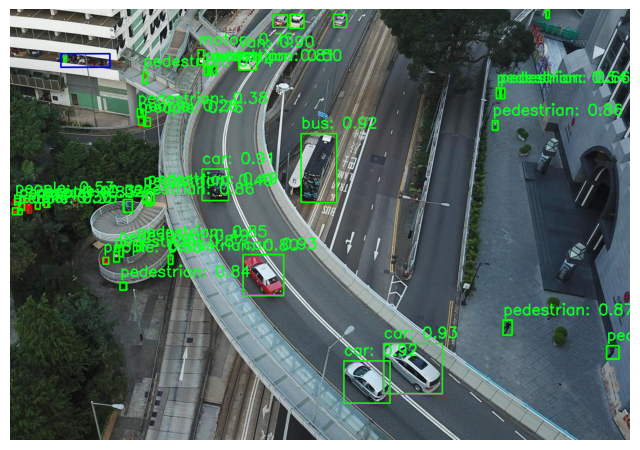


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1011.jpg: 352x640 25 pedestrians, 3 cars, 1 bus, 102.3ms
Speed: 2.9ms preprocess, 102.3ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 3, Confidence: 0.9521986246109009, BBox: (138, 413, 206, 528)
Class: 3, Confidence: 0.9300478100776672, BBox: (215, 76, 275, 179)
Class: 3, Confidence: 0.9122558832168579, BBox: (657, 327, 712, 441)
Class: 0, Confidence: 0.8898225426673889, BBox: (1151, 6, 1169, 33)
Class: 0, Confidence: 0.8884209394454956, BBox: (1065, 35, 1087, 52)
Class: 8, Confidence: 0.8829354643821716, BBox: (216, 75, 363, 356)
Class: 0, Confidence: 0.8626066446304321, BBox: (435, 246, 454, 264)
Class: 0, Confidence: 0.8395199775695801, BBox: (1214, 457, 1231, 469)
Class: 0, Confidence: 0.8288609981536865, BBox: (1168, 14, 1187, 41)
Class: 0, Confidence: 0.8247258067131042, BBox: (1222, 661, 1250, 685)
Class: 0, Confidence: 0.8062968850135803, BBox: (340, 567, 363, 582)
Class: 0, Confidence: 0.79326993227005, BBox: (86, 205, 107, 226)
Class: 0, Confidence: 0.7835288047790527, BBox: (1130, 14, 1151, 40)
Class: 0, Confidence: 0.7613160610198975, BBox: (1236, 684, 1262, 699)
Class: 0, C

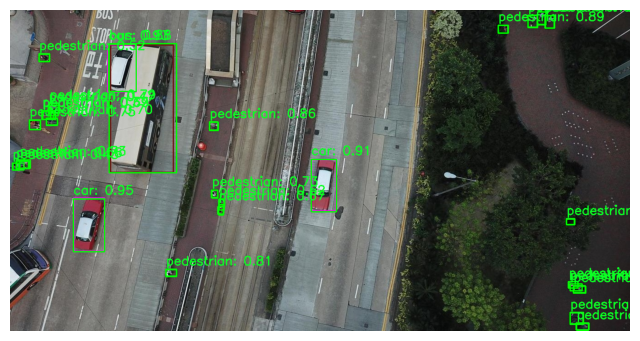


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/932.jpg: 352x640 4 cars, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 3, Confidence: 0.8918914198875427, BBox: (498, 521, 534, 591)
Class: 3, Confidence: 0.8794131875038147, BBox: (556, 131, 583, 175)
Class: 3, Confidence: 0.8779844045639038, BBox: (265, 127, 317, 161)
Class: 3, Confidence: 0.8610617518424988, BBox: (598, 58, 620, 102)


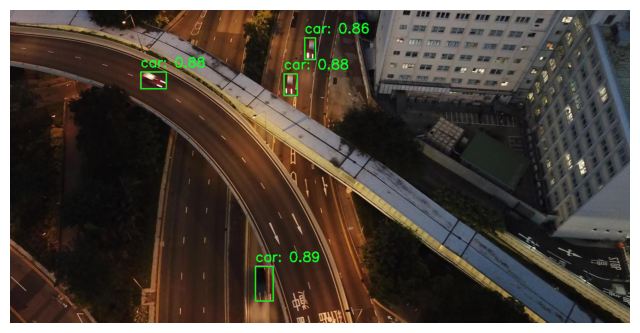


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/846.jpg: 352x640 9 pedestrians, 1 people, 6 bicycles, 24 cars, 1 van, 1 motor, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 2, Confidence: 0.9583105444908142, BBox: (1180, 315, 1206, 342)
Class: 3, Confidence: 0.9537010788917542, BBox: (619, 512, 799, 653)
Class: 3, Confidence: 0.9317024350166321, BBox: (559, 419, 687, 509)
Class: 2, Confidence: 0.9305567741394043, BBox: (1118, 293, 1153, 315)
Class: 4, Confidence: 0.8971737027168274, BBox: (176, 295, 251, 346)
Class: 3, Confidence: 0.8909033536911011, BBox: (646, 324, 693, 369)
Class: 3, Confidence: 0.8904270529747009, BBox: (520, 311, 569, 367)
Class: 3, Confidence: 0.8817428946495056, BBox: (845, 267, 897, 300)
Class: 3, Confidence: 0.8760471343994141, BBox: (625, 231, 646, 253)
Class: 3, Confidence: 0.8632874488830566, BBox: (884, 286, 935, 318)
Class: 3, Confidence: 0.8593935966491699, BBox: (499, 236, 535, 270)
Class: 3, Confidence: 0.8592449426651001, BBox: (690, 268, 734, 301)
Class: 3, Confidence: 0.8586031198501587, BBox: (550, 185, 566, 202)
Class: 2, Confidence: 0.8499606251716614, BBox: (1146, 312, 1172, 333)
Class

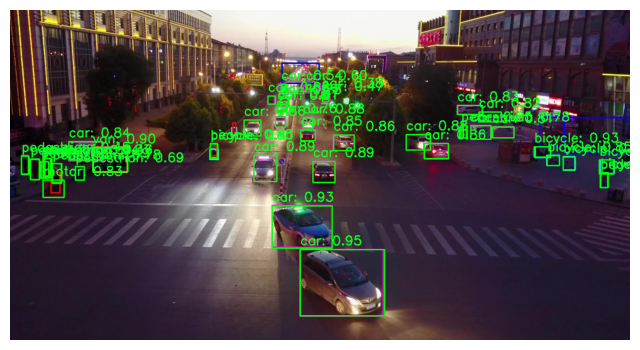


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/493.jpg: 320x640 7 cars, 1 van, 1 bus, 90.7ms
Speed: 2.0ms preprocess, 90.7ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)


Predicted Annotations:
Class: 3, Confidence: 0.9042538404464722, BBox: (613, 266, 648, 309)
Class: 3, Confidence: 0.8893944025039673, BBox: (473, 361, 498, 402)
Class: 4, Confidence: 0.8821107745170593, BBox: (812, 514, 859, 537)
Class: 3, Confidence: 0.8779823780059814, BBox: (515, 242, 536, 290)
Class: 3, Confidence: 0.8730167150497437, BBox: (439, 126, 459, 177)
Class: 3, Confidence: 0.8654630780220032, BBox: (428, 5, 449, 58)
Class: 8, Confidence: 0.8599688410758972, BBox: (989, 520, 1113, 554)
Class: 3, Confidence: 0.8432460427284241, BBox: (376, 216, 393, 259)
Class: 3, Confidence: 0.8422346115112305, BBox: (1160, 396, 1212, 416)


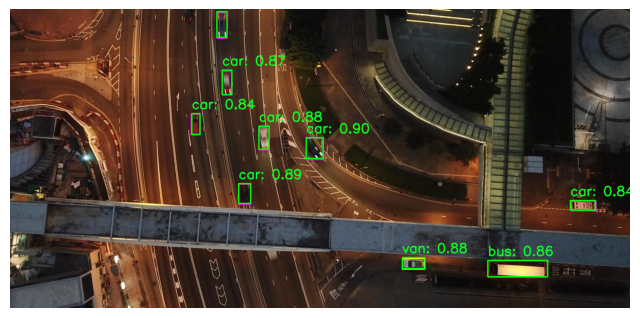

In [26]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO


# Load the trained YOLOv8 model
model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model
# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = [1,1011,932,846,493]
for img_locat in listimg:
    # Define the test image path
    # test_image_path = '/kaggle/input/custom-dataset/images/1001.jpg'
    test_image_path = '/kaggle/input/extended-dataset/Expanded_dataset/images/'+ str(img_locat) + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 6.b. Make Predictions on visdrone from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000006_00159_d_0000001.jpg: 384x640 (no detections), 90.7ms
Speed: 2.1ms preprocess, 90.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Predicted Annotations:


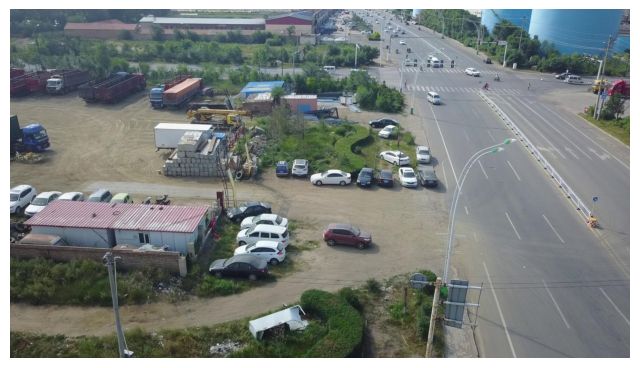


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000054_00786_d_0000001.jpg: 384x640 (no detections), 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Predicted Annotations:


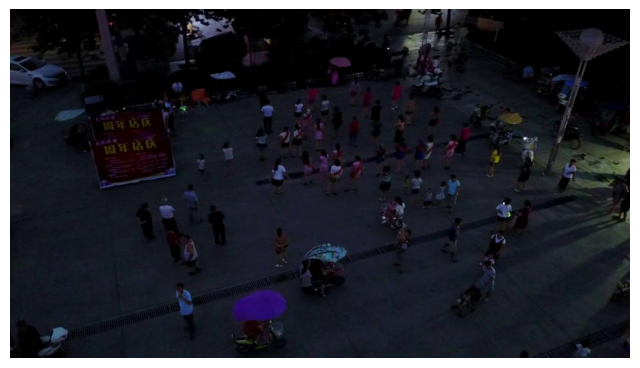

In [27]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model

# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = ['0000006_00159_d_0000001','0000054_00786_d_0000001']
for img_locat in listimg:
    # Define the test image path
    # test_image_path = '/kaggle/input/custom-dataset/images/1001.jpg'
    test_image_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/'+ img_locat + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [28]:
# shutil.rmtree('/kaggle/working/yolo_dataset/val')

# Extra

In [29]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/test

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
    file.write(data_config)

In [30]:
# Load the best model
model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model
# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluate the model on the new dataset
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:40<00:00,  2.47it/s]
                   all       1610      75367    0.00944     0.0287    0.00631    0.00207
            pedestrian       1610      21006    0.00325    0.00371    0.00163   0.000389
                people       1610       6376    0.00378     0.0107    0.00196   0.000441
               bicycle       1610      